In [22]:
import sys
import uproot # for reading .root files
import pandas as pd # to store data as dataframe
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks
from lmfit.models import PolynomialModel, GaussianModel # for the signal and background fits
import requests # for HTTP access
import aiohttp # HTTP client support

In [2]:
#lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 1 # reduce this is you want the code to run quicker

#tuple_path = "Input/GamGam/Data/" # local 
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/" # web address

In [3]:
samples_list = ['data_A','data_B','data_C','data_D'] # add if you want more data


In [4]:
def get_data_from_files():

    frames = [] # define empty list to hold data
    for val in samples_list: # loop over each file
        fileString = tuple_path+val+".GamGam.root" # file name to open
        temp = read_file(fileString,val) # call the function read_file defined below
        frames.append(temp) # append dataframe returned from read_file to list of dataframes
    data = pd.concat(frames) # concatenate list of dataframes together into one dataframe
    
    return data # return dataframe

In [76]:
def calc_myy(photon_pt,photon_eta,photon_phi,photon_E):
    # first photon is [0], 2nd photon is [1] etc
    print(photon_pt)
    px_0 = photon_pt[0]*math.cos(photon_phi[0]) # x-component of photon[0] momentum
    py_0 = photon_pt[0]*math.sin(photon_phi[0]) # y-component of photon[0] momentum
    pz_0 = photon_pt[0]*math.sinh(photon_eta[0]) # z-component of photon[0] momentum
    px_1 = photon_pt[1]*math.cos(photon_phi[1]) # x-component of photon[1] momentum
    py_1 = photon_pt[1]*math.sin(photon_phi[1]) # y-component of photon[1] momentum
    pz_1 = photon_pt[1]*math.sinh(photon_eta[1]) # z-component of photon[1] momentum
    sumpx = px_0 + px_1 # x-component of diphoton momentum
    sumpy = py_0 + py_1 # y-component of diphoton momentum
    sumpz = pz_0 + pz_1 # z-component of diphoton momentum 
    sump = math.sqrt(sumpx**2 + sumpy**2 + sumpz**2) # magnitude of diphoton momentum 
    sumE = photon_E[0] + photon_E[1] # energy of diphoton system
    print(sumE, sump)
    return math.sqrt(sumE**2 - sump**2)/1000 #/1000 to go from MeV to GeV

In [6]:
# Cut on photon reconstruction quality
# paper: "Photon candidates are required to pass identification criteria"
def cut_photon_reconstruction(photon_isTightID):
# isTightID==True means a photon identified as being well reconstructed
# want to keep events where True for both photons
# first photon is [0], 2nd photon is [1] etc
    return photon_isTightID[0]==True and photon_isTightID[1]==True
    
# Cut on Transverse momentum
# paper: "The leading (sub-leading) photon candidate is required to have ET > 40 GeV (30 GeV)"
def cut_photon_pt(photon_pt):
# want to keep events where photon_pt[0]>40000 MeV and photon_pt[1]>30000 MeV
    return photon_pt[0]>40000 and photon_pt[1]>30000

# Cut on energy isolation
# paper: "Photon candidates are required to have an isolation transverse energy of less than 4 GeV"
def cut_isolation_et(photon_etcone20):
# want to keep events where isolation eT<4000 MeV
    return photon_etcone20[0]<4000 and photon_etcone20[1]<4000

# Cut on pseudorapidity in barrel/end-cap transition region
# paper: "excluding the calorimeter barrel/end-cap transition region 1.37 < |η| < 1.52"
def cut_photon_eta_transition(photon_eta):
# want to keep events where modulus of photon_eta is outside the range 1.37 to 1.52
    return (abs(photon_eta[0])>1.52 or abs(photon_eta[0])<1.37) and (abs(photon_eta[1])>1.52 or abs(photon_eta[1])<1.37)

In [7]:
def read_file(path,sample):
    start = time.time() # start the clock
    print("Processing: "+sample) # print which sample is being processed
    data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
    tree = uproot.open(path + ":mini")
    numevents = tree.num_entries # number of events
    for data in tree.iterate(["photon_pt","photon_eta","photon_phi","photon_E",
                            "photon_isTightID","photon_etcone20"], # add more variables here if you want to use them
                           library="pd", # choose output type as pandas DataFrame
                           entry_stop=numevents*fraction): # process up to numevents*fraction

        nIn = len(data.index) # number of events in this batch
        
        # Cut on photon reconstruction quality using the function cut_photon_reconstruction defined above
        data = data[ np.vectorize(cut_photon_reconstruction)(data.photon_isTightID)]
        
        # Cut on transverse momentum of the photons using the function cut_photon_pt defined above
        data = data[ np.vectorize(cut_photon_pt)(data.photon_pt)]
        
        # Cut on energy isolation using the function cut_isolation_et defined above
        data = data[ np.vectorize(cut_isolation_et)(data.photon_etcone20)]
        
        # Cut on pseudorapidity inside barrel/end-cap transition region using the function cut_photon_eta_transition
        data = data[ np.vectorize(cut_photon_eta_transition)(data.photon_eta)]
        
        # Calculate reconstructed diphoton invariant mass using the function calc_myy defined above
        data['myy'] = np.vectorize(calc_myy)(data.photon_pt,data.photon_eta,data.photon_phi,data.photon_E)
        
        # dataframe contents can be printed at any stage like this
        #print(data)

        # dataframe column can be printed at any stage like this
        #print(data['photon_pt'])

        # multiple dataframe columns can be printed at any stage like this
        #print(data[['photon_pt','photon_eta']])

        nOut = len(data.index) # number of events passing cuts in this batch
        data_all = pd.concat([data_all, data], ignore_index=True)
        elapsed = time.time() - start # time taken to process
        print("\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return data_all # return dataframe containing events passing all cuts

In [8]:
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file


Processing: data_A
	 nIn: 430344,	 nOut: 	22350	 in 6.3s
Processing: data_B
	 nIn: 1528717,	 nOut: 	77574	 in 11.9s
Processing: data_C
	 nIn: 1991156,	 nOut: 	101273	 in 16.4s
	 nIn: 246031,	 nOut: 	12824	 in 86.1s
Processing: data_D
	 nIn: 1912410,	 nOut: 	96464	 in 17.6s
	 nIn: 1689766,	 nOut: 	87478	 in 143.8s
Time taken: 458.3s


In [9]:
def plot_data(data):   

    xmin = 100 # GeV
    xmax = 160 # GeV
    step_size = 3 # GeV
    
    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['myy'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    # data fit
    polynomial_mod = PolynomialModel( 4 ) # 4th order polynomial
    gaussian_mod = GaussianModel() # Gaussian
    
    # set initial guesses for the parameters of the polynomial model
    # c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    pars = polynomial_mod.guess(data_x, # data to use to guess parameter values
                                x=bin_centres, c0=data_x.max(), c1=0,
                                c2=0, c3=0, c4=0 )
    
    # set initial guesses for the parameters of the Gaussian model
    pars += gaussian_mod.guess(data_x, # data to use to guess parameter values
                               x=bin_centres, amplitude=100, 
                               center=125, sigma=2 )
    
    model = polynomial_mod + gaussian_mod # combined model
    
    # fit the model to the data
    out = model.fit(data_x, # data to be fit
                    pars, # guesses for the parameters
                    x=bin_centres, weights=1/data_x_errors ) 

    # background part of fit
    params_dict = out.params.valuesdict() # get the parameters from the fit to data
    c0 = params_dict['c0'] # c0 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c1 = params_dict['c1'] # c1 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c2 = params_dict['c2'] # c2 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c3 = params_dict['c3'] # c3 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c4 = params_dict['c4'] # c4 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    
    # get the background only part of the fit to data
    background = c0 + c1*bin_centres + c2*bin_centres**2 + c3*bin_centres**3 + c4*bin_centres**4

    # data fit - background fit = signal fit
    signal_x = data_x - background 


    # *************
    # Main plot 
    # *************
    plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height 
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors, 
                       fmt='ko', # 'k' means black and 'o' means circles
                       label='Data' ) 
    
    # plot the signal + background fit
    main_axes.plot(bin_centres, # x
                   out.best_fit, # y
                   '-r', # single red line
                   label='Sig+Bkg Fit ($m_H=125$ GeV)' )
    
    # plot the background only fit
    main_axes.plot(bin_centres, # x
                   background, # y
                   '--r', # dashed red line
                   label='Bkg (4th order polynomial)' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x-axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          labelbottom=False, # don't draw tick labels on bottom axis
                          right=True ) # draw ticks on right axis
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV', 
                         horizontalalignment='right') 
    
    # set the y-axis limit for the main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.1 ) 
    
    # set minor ticks on the y-axis of the main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.2, # x
             0.92, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.2, # x
             0.86, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.2, # x
             0.8, # y
             r'$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+r' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes 
    
    # Add a label for the analysis carried out
    plt.text(0.2, # x
             0.74, # y
             r'$H \rightarrow \gamma\gamma$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend(frameon=False, # no box around the legend
                     loc='lower left' ) # legend location 


    # *************
    # Data-Bkg plot 
    # *************
    plt.axes([0.1,0.1,0.85,0.2]) # left, bottom, width, height
    sub_axes = plt.gca() # get the current axes
    
    # set the y axis to be symmetric about Data-Background=0
    sub_axes.yaxis.set_major_locator( MaxNLocator(nbins='auto', 
                                                  symmetric=True) )
    
    # plot Data-Background
    sub_axes.errorbar(x=bin_centres, y=signal_x, yerr=data_x_errors,
                      fmt='ko' ) # 'k' means black and 'o' means circles
    
    # draw the fit to data
    sub_axes.plot(bin_centres, # x
                  out.best_fit-background, # y
                  '-r' ) # single red line
    
    # draw the background only fit
    sub_axes.plot(bin_centres, # x
                  background-background, # y
                  '--r' )  # dashed red line
    
    # set the x-axis limits on the sub axes
    sub_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x-axis minor ticks
    sub_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # x-axis label
    sub_axes.set_xlabel(r'di-photon invariant mass $\mathrm{m_{\gamma\gamma}}$ [GeV]',
                        x=1, horizontalalignment='right', 
                        fontsize=13 ) 
    
    # set the tick parameters for the sub axes
    sub_axes.tick_params(which='both', # ticks on both x and y axes
                         direction='in', # Put ticks inside and outside the axes
                         top=True, # draw ticks on the top axis
                         right=True ) # draw ticks on right axis 
    
    # separation of y-axis minor ticks
    sub_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # y-axis label on the sub axes
    sub_axes.set_ylabel( 'Events-Bkg' ) 


    # Generic features for both plots
    main_axes.yaxis.set_label_coords( -0.09, 1 ) # x,y coordinates of the y-axis label on the main axes
    sub_axes.yaxis.set_label_coords( -0.09, 0.5 ) # x,y coordinates of the y-axis label on the sub axes
    
    plt.savefig("correct_HyyAnalysis_graph.png")
    return bin_centres, out, background, params_dict

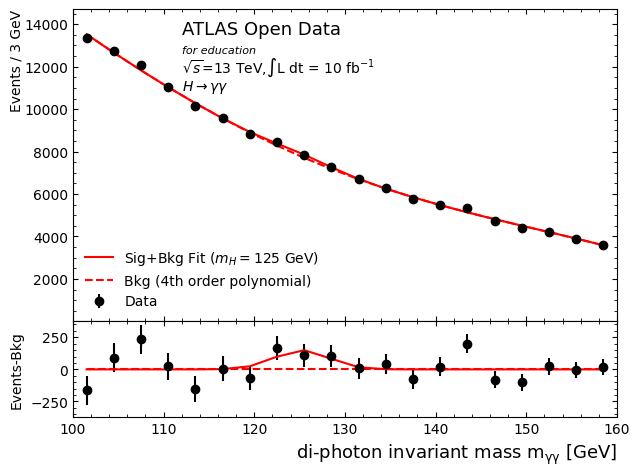

In [10]:
bin_centres, out, background, params_dict = plot_data(data)

In [21]:
# print(params_dict)
mean = params_dict["center"]
sigma = params_dict["sigma"]
one_std = (mean - sigma, mean+sigma)

print(bin_centres)
centre_idx = np.where(bin_centres == 125.5)[0]
n_sig = out.best_fit[centre_idx]
n_bg = background[centre_idx]
diff = n_sig - n_bg

print(n_sig/np.sqrt(n_bg + 0.3*n_bg**2))
print(diff)


[101.5 104.5 107.5 110.5 113.5 116.5 119.5 122.5 125.5 128.5 131.5 134.5
 137.5 140.5 143.5 146.5 149.5 152.5 155.5 158.5]
[1.86079331]
[149.66244712]


In [12]:
def filter_len_2(series):
    lens = series.apply(len)
    mask = (lens == 2).to_numpy()
    return series[mask]

photon_pts = filter_len_2(data["photon_pt"]).to_numpy()
photon_etas = filter_len_2(data["photon_eta"]).to_numpy()
photon_phis = filter_len_2(data["photon_phi"]).to_numpy()
photon_Es = filter_len_2(data["photon_E"]).to_numpy()

In [14]:
data_new = np.column_stack([photon_pts, photon_etas, photon_phis, photon_Es]).astype(np.float64)
names = np.array(["photon_pt_1", "photon_pt_2", "photon_eta_1", "photon_eta_2", "photon_phi_1", "photon_phi_2", "photon_E_1", "photon_E_2"])
print(data_new.shape)
print(type(data_new))
print(type(data_new[0]))
print(type(data_new[0][0]))
np.savez("/gluster/home/ofrebato/baler/workspaces/higgs/data/13TeV_combined_cut_numpy.npz", data=data_new, names=names)


(396373, 8)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>


In [72]:
orig = np.load("/gluster/home/ofrebato/baler/workspaces/higgs/data/13TeV_combined_cut_numpy.npz")
comp = np.load("/gluster/home/ofrebato/baler/workspaces/higgs/higgs_project/output/compressed_output/compressed.npz")
decomp = np.load("/gluster/home/ofrebato/baler/workspaces/higgs/higgs_project/output/decompressed_output/decompressed.npz")

photon_pts = decomp["data"][:,0:2]
photon_etas = decomp["data"][:,2:4]
photon_phis = decomp["data"][:,4:6]
photon_Es = decomp["data"][:,6:8]

print(comp["data"].shape)
print(sys.getsizeof(orig["data"])/1024**2)
print(sys.getsizeof(comp["data"])/1024**2)
print(sys.getsizeof(decomp["data"])/1024**2)


(396373, 1)
24.19281005859375
3.0242080688476562
24.19281005859375


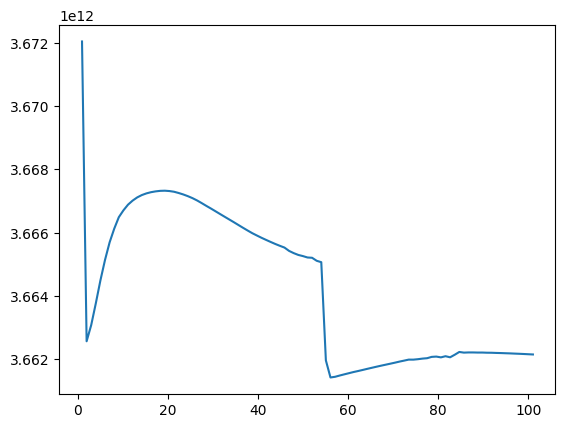

In [39]:
loss_dats = np.load("/gluster/home/ofrebato/baler/workspaces/higgs/higgs_project/output/training/loss_data.npy")
fig, ax = plt.subplots()
x = np.linspace(1, 101, 99)
ax.plot(x, loss_dats[0,1:])
plt.show()


In [82]:
print(photon_pts[0])
print(photon_pts.shape)
masses2 = calc_myy(data_new[0,:2], data_new[0,2:4], data_new[0,4:6], data_new[0,6:8])
masses = calc_myy(photon_pts[0],photon_etas[0],photon_phis[0],photon_Es[0])




[96699.90949216 60611.02844882]
(396373, 2)
[176121.15625     39629.14453125]
280729.30078125 259776.00732189883
[96699.90949216 60611.02844882]
345964.9780018153 1.246238174691732e+46


ValueError: math domain error

In [70]:
E_diffs = data_new[:,6:8] - photon_Es
dists = np.sqrt(np.sum(E_diffs**2, axis=1))
fracs = dists/np.sum(data_new[:,6:8], axis=1)
print(max(dists), min(dists))
print(max(fracs), min(fracs))


1388982.988365242 10.132909323550932
0.6544722206675339 6.148671529464911e-05


In [67]:
eta_diffs = data_new[:,2:4] - photon_etas
dists = np.sqrt(np.sum(eta_diffs**2, axis=1))
print(max(dists), min(dists))
idx = np.where(dists == max(dists))[0]
print(data_new[idx, 2:4], photon_etas[idx])
print(np.amin(data_new[:,2:4]))
print(data_new[0])


1000.5151836498426 23.639339344590002
[[-2.35569692 -2.22434497]] [[307.05990676 949.24431816]]
-2.4035074710845947
[ 1.76121156e+05  3.96291445e+04 -8.33491981e-01  9.47030708e-02
 -2.94238716e-01  5.67293763e-01  2.40922312e+05  3.98069883e+04]


In [83]:
E_diffs = data_new[:,6:8] - photon_Es
dists = np.sqrt(np.sum(E_diffs**2, axis=1))
print(max(dists), min(dists))

1388982.988365242 10.132909323550932


In [84]:
data_path = "/gluster/home/ofrebato/baler/workspaces/higgs/data/"
np.savez(data_path+"13TeV_photon_pt.npz", data=data_new[:,0:2], names=["pt1", "pt2"])
np.savez(data_path+"13TeV_photon_eta.npz", data=data_new[:,2:4], names=["eta1", "eta2"])
np.savez(data_path+"13TeV_photon_phi.npz", data=data_new[:,4:6], names=["phi1", "phi2"])
np.savez(data_path+"13TeV_photon_E.npz", data=data_new[:,6:8], names=["E1", "E2"])
